<img src="https://i.imgur.com/I08M6KP.png" width="600px">

# Introduction

In this project, I will try to finetune a roBERTa base transformer model to predict whether a Quora question is sincere or insincere. An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

* Has a non-neutral tone
  * Has an exaggerated tone to underscore a point about a group of people
  * Is rhetorical and meant to imply a statement about a group of people
  

* Is disparaging or inflammatory
  * Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
  * Makes disparaging attacks/insults against a specific person or group of people
  * Based on an outlandish premise about a group of people
  * Disparages against a characteristic that is not fixable and not measurable
  

* Isn't grounded in reality
  * Based on false information, or contains absurd assumptions
  

* Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

Solving this problem will help combat online trolls at scale and help Quora uphold their policy of “Be Nice, Be Respectful” and continue to be a place for sharing and growing the world’s knowledge. I will use **PyTorch XLA** (PyTorch for TPUs) and **huggingface transformers** for this project.

## Set up PyTorch-XLA

* These few lines of code sets up PyTorch XLA for us.
* We need PyTorch XLA to help us train PyTorch models on TPU.

In [1]:
!export PIP_DISABLE_PIP_VERSION_CHECK=1
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
!export XLA_USE_BF16=1
!pip install -q colored

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  18701      0 --:--:-- --:--:-- --:--:-- 18701
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
Found existing installation: torch 1.5.0
Uninstalling torch-1.5.0:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torch-1.5.0
Found existing installation: torchvision 0.6.0a0+82fd1c8
Uninstalling torchvision-0.6.0a0+82fd1c8:
  Successfully uninstalled torchvision-0.6.0a0+82fd1c8
Copying gs://tpu-pytorch/wheels/torch-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/91.1 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/120.3 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchv

## Install and import libraries

* We will import several different packages and libraries required for different parts of the project. For example, we import numpy and pandas for data manipulation, torch and torch_xla for modeling, and matplotlib for visualization.

In [2]:
import os
import gc
import time
import colored
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colored import fg, bg, attr

import torch
import torch.nn as nn
from torch.optim import Adam
from torch import LongTensor, FloatTensor, DoubleTensor
from torch.utils.data import Dataset, DataLoader, sampler
from torch.utils.data.distributed import DistributedSampler

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from transformers import RobertaModel, RobertaTokenizer

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences as pad

Using TensorFlow backend.


## Define hyperparameters and load data

* Here, we define the required hyperparameters such as the training batch size, learning rate, training/validation split percentage, etc.
* We also load the training and tessting data required for the project using the read_csv function from the pandas library.

In [3]:
EPOCHS = 2
SPLIT = 0.8
DROP_RATE = 0.3
MAXLEN = 64 # 70
LR = (4e-5, 1e-2)
BATCH_SIZE = 256
VAL_BATCH_SIZE = 8192
MODEL_SAVE_PATH = 'insincerity_model.pt'

In [4]:
np.random.seed(42)
torch.manual_seed(42)

In [5]:
test_df = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
train_df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')

In [6]:
test_df.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [7]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


## Define PyTorch Dataset

* Now we define a PyTorch Dataset which will help us feed data to the roBERTa model for training and inference.
* We remove leading and trailing whitespaces using .strip(), tokenize the values using huggingface, and pad the tokens using keras.

In [8]:
class QuoraDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.target = data.target
        self.tokenizer = tokenizer
        self.text = data.question_text

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        pg, tg = 'post', 'post'
        target = [self.target[i]]
        question = str(self.text[i])
        quest_ids = self.tokenizer.encode(question.strip())

        attention_mask_idx = len(quest_ids) - 1
        if 0 not in quest_ids: quest_ids = 0 + quest_ids
        quest_ids = pad([quest_ids], maxlen=MAXLEN, value=1, padding=pg, truncating=tg)

        attention_mask = np.zeros(MAXLEN)
        attention_mask[1:attention_mask_idx] = 1
        attention_mask = attention_mask.reshape((1, -1))
        if 2 not in quest_ids: quest_ids[-1], attention_mask[-1] = 2, 0
        return FloatTensor(target), LongTensor(quest_ids), LongTensor(attention_mask)

## Define tokenizer

* Here we simply define the RobertaTokenizer from huggingface which we use in the Dataset to generate tokens from words.

In [9]:
model = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model)

## Define roBERTa-base model

* Now, we get to the interesting part: training roBERTa base! roBERTa base is a pretrained language model developed by Facebook AI.
* We will use roBERTa with its pretrained weights and add a custom (Dropout + Dense) head at the top to turn it into a binary text classifier.

In [10]:
class Roberta(nn.Module):
    def __init__(self):
        super(Roberta, self).__init__()
        self.dropout = nn.Dropout(DROP_RATE)
        self.dense_output = nn.Linear(768, 1)
        self.roberta = RobertaModel.from_pretrained(model)

    def forward(self, inp, att):
        inp = inp.view(-1, MAXLEN)
        _, self.feat = self.roberta(inp, att)
        return self.dense_output(self.dropout(self.feat))

In [11]:
m = Roberta()

In [12]:
del m; gc.collect()

488

## Define binary cross entropy and F1 score in PyTorch

* Here we implement binary cross entropy and F1 score functions in PyTorch.
* BCE is the loss function which is commonly used in binary classification tasks and helps us finetune roBERTa's weights.
* F1 Score is an evaluation metric ranging from 0 to 1, and we use it instead of accuracy because it is immune to class imabalance.
* Our dataset is almost 93% sincere and 7% insincere. This extreme imbalance makes accuracy an unreliable metric and thus, F1 Score.



In [13]:
def bce(y_pred, y_true):
    return nn.BCEWithLogitsLoss()(y_pred, y_true)*len(y_pred)

def f1_score(y_pred, y_true):
    y_true = y_true.squeeze()
    y_pred = torch.round(nn.Sigmoid()(y_pred)).squeeze()
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    recall = tp / (tp + fn + epsilon)
    precision = tp / (tp + fp + epsilon)
    return 2*(precision*recall) / (precision + recall + epsilon)

## Split data and train model on all 8 TPU cores

* Now, we will train the roBERTa base model to classify tweet sentiments.
* We define a simple training loop in PyTorch to train the model and validate it after each epoch.
* We parallelize the training on all 8 TPU cores using <code>xmp.spawn</code> from PyTorch XLA (distributes training).
* We aslo use <code>DistributedSampler</code> and <code>ParallelLoader</code> to parallelize data sampling and model training.

In [14]:
def print_metric(data, batch, epoch, start, end, metric, typ):
    t = typ, metric, "%s", data, "%s"
    if typ == "Train": pre = "BATCH %s" + str(batch-1) + "%s  "
    if typ == "Val": pre = "\nEPOCH %s" + str(epoch+1) + "%s  "
    time = np.round(end - start, 1); time = "Time: %s{}%s s".format(time)
    fs = [(fg(211), attr('reset')), (fg(212), attr('reset')), (fg(213), attr('reset'))]
    xm.master_print(pre % fs[0] + "{} {}: {}{}{}".format(*t) % fs[1] + "  " + time % fs[2])

In [15]:
global val_f1s; global train_f1s
global val_losses; global train_losses

def train_fn(df):
    size = 1; torch.manual_seed(42)

    df = shuffle(df)
    split = np.int32(SPLIT*len(df))
    val_df, train_df = df[split:], df[:split]

    val_df = val_df.reset_index(drop=True)
    val_set = QuoraDataset(val_df, tokenizer)
    val_sampler = DistributedSampler(val_set, num_replicas=8,
                                     rank=xm.get_ordinal(), shuffle=True)

    train_df = train_df.reset_index(drop=True)
    train_set = QuoraDataset(train_df, tokenizer)
    train_sampler = DistributedSampler(train_set, num_replicas=8,
                                       rank=xm.get_ordinal(), shuffle=True)
    
    val_loader = DataLoader(val_set, VAL_BATCH_SIZE,
                            sampler=val_sampler, num_workers=0, drop_last=True)

    train_loader = DataLoader(train_set, BATCH_SIZE,
                              sampler=train_sampler, num_workers=0, drop_last=True)

    device = xm.xla_device()
    network = Roberta().to(device)
    optimizer = Adam([{'params': network.roberta.parameters(), 'lr': LR[0]*size},
                      {'params': network.dense_output.parameters(), 'lr': LR[1]*size}])

    val_losses, val_f1s = [], []
    train_losses, train_f1s = [], []
    
    start = time.time()
    xm.master_print("STARTING TRAINING ...\n")

    for epoch in range(EPOCHS):

        batch = 1
        network.train()
        fs = (fg(48), attr('reset'))
        xm.master_print(("EPOCH %s" + str(epoch+1) + "%s") % fs)

        val_parallel = pl.ParallelLoader(val_loader, [device]).per_device_loader(device)
        train_parallel = pl.ParallelLoader(train_loader, [device]).per_device_loader(device)
        
        for train_batch in train_parallel:
            train_targ, train_in, train_att = train_batch
            
            network = network.to(device)
            train_in = train_in.to(device)
            train_att = train_att.to(device)
            train_targ = train_targ.to(device)

            train_preds = network.forward(train_in, train_att)
            train_loss = bce(train_preds, train_targ)/len(train_preds)
            train_f1 = f1_score(train_preds, train_targ.squeeze(dim=1))

            optimizer.zero_grad()
            train_loss.backward()
            xm.optimizer_step(optimizer)
            
            end = time.time()
            batch = batch + 1
            is_print = batch % 10 == 1
            f1 = np.round(train_f1.item(), 3)
            if is_print: print_metric(f1, batch, None, start, end, metric="F1", typ="Train")

        val_loss, val_f1, val_points = 0, 0, 0

        network.eval()
        with torch.no_grad():
            for val_batch in val_parallel:
                targ, val_in, val_att = val_batch

                targ = targ.to(device)
                val_in = val_in.to(device)
                val_att = val_att.to(device)
                network = network.to(device)
                pred = network.forward(val_in, val_att)

                val_points += len(targ)
                val_loss += bce(pred, targ).item()
                val_f1 += f1_score(pred, targ.squeeze(dim=1)).item()*len(pred)
        
        end = time.time()
        val_f1 /= val_points
        val_loss /= val_points
        f1 = xm.mesh_reduce('f1', val_f1, lambda x: sum(x)/len(x))
        loss = xm.mesh_reduce('loss', val_loss, lambda x: sum(x)/len(x))
        print_metric(np.round(f1, 3), None, epoch, start, end, metric="F1", typ="Val")
    
        xm.master_print("")
        val_f1s.append(f1); train_f1s.append(train_f1.item())
        val_losses.append(loss); train_losses.append(train_loss.item())

    xm.master_print("ENDING TRAINING ...")
    xm.save(network.state_dict(), MODEL_SAVE_PATH); del network; gc.collect()
    
    metric_lists = [val_losses, train_losses, val_f1s, train_f1s]
    metric_names = ['val_loss_', 'train_loss_', 'val_f1_', 'train_f1_']
    
    for i, metric_list in enumerate(metric_lists):
        for j, metric_value in enumerate(metric_list):
            torch.save(metric_value, metric_names[i] + str(j) + '.pt')

In [16]:
FLAGS = {}
def _mp_fn(rank, flags): train_fn(df=train_df)
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

STARTING TRAINING ...

EPOCH 1
BATCH 10  Train F1: 0.0  Time: 208.5 s
BATCH 20  Train F1: 0.0  Time: 219.3 s
BATCH 30  Train F1: 0.0  Time: 229.7 s
BATCH 40  Train F1: 0.511  Time: 240.3 s
BATCH 50  Train F1: 0.545  Time: 251.1 s
BATCH 60  Train F1: 0.634  Time: 261.8 s
BATCH 70  Train F1: 0.522  Time: 272.2 s
BATCH 80  Train F1: 0.526  Time: 282.8 s
BATCH 90  Train F1: 0.593  Time: 293.2 s
BATCH 100  Train F1: 0.37  Time: 303.9 s
BATCH 110  Train F1: 0.667  Time: 314.6 s
BATCH 120  Train F1: 0.732  Time: 325.3 s
BATCH 130  Train F1: 0.69  Time: 335.7 s
BATCH 140  Train F1: 0.538  Time: 346.2 s
BATCH 150  Train F1: 0.333  Time: 356.6 s
BATCH 160  Train F1: 0.714  Time: 367.3 s
BATCH 170  Train F1: 0.345  Time: 378.1 s
BATCH 180  Train F1: 0.522  Time: 388.6 s
BATCH 190  Train F1: 0.696  Time: 399.1 s
BATCH 200  Train F1: 0.667  Time: 409.6 s
BATCH 210  Train F1: 0.812  Time: 420.0 s
BATCH 220  Train F1: 0.643  Time: 430.8 s
BATCH 230  Train F1: 0.72  Time: 441.3 s
BATCH 240  Train F1: 

## Visualize loss and F1 score over time

* We now visualize how the loss and accuracy of the model change over time.
* We can see that the model eventually converges to around 0.7 F1 Score at the end.

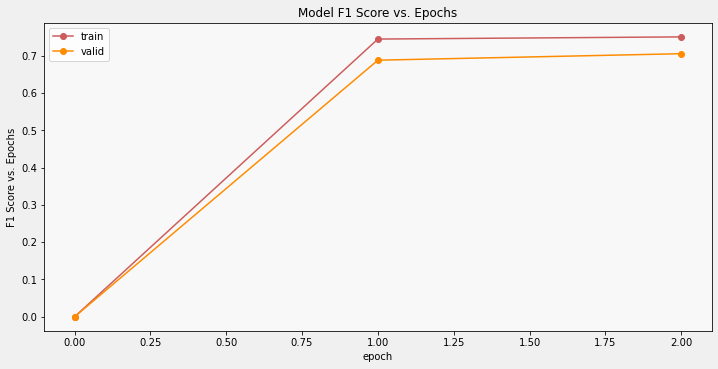

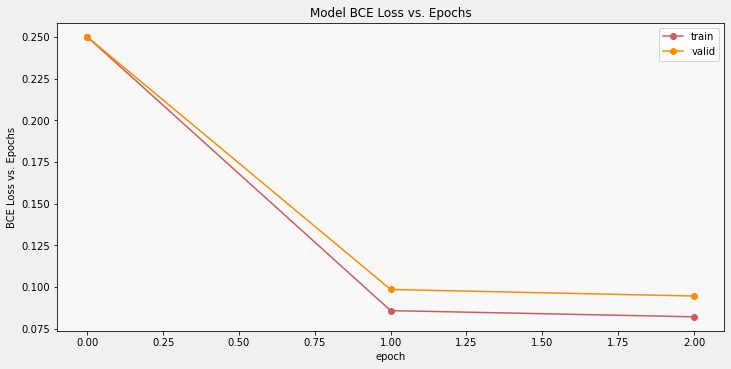

In [17]:
def display_training_curves(training, validation, title, subplot):

    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()

    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training, color="indianred", marker='o')
    ax.plot(validation, color="darkorange", marker='o')
    
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.set_title('Model '+ title)
    ax.legend(['train', 'valid'])

    
val_f1s = [0] + [torch.load('val_f1_{}.pt'.format(i)) for i in range(EPOCHS)]
train_f1s = [0] + [torch.load('train_f1_{}.pt'.format(i)) for i in range(EPOCHS)]
val_losses = [0.25] + [torch.load('val_loss_{}.pt'.format(i)) for i in range(EPOCHS)]
train_losses = [0.25] + [torch.load('train_loss_{}.pt'.format(i)) for i in range(EPOCHS)]

display_training_curves(train_f1s, val_f1s, "F1 Score vs. Epochs", 212)
display_training_curves(train_losses, val_losses, "BCE Loss vs. Epochs", 211)

## Load model and check sample performance

* We first load the model to check its performance.
* We will now see how the model performs on sample questions.
* It appears to classify insincerity pretty accurately in these simple examples.

In [18]:
network = Roberta()
network.load_state_dict(torch.load('insincerity_model.pt'))

<All keys matched successfully>

In [19]:
device = xm.xla_device()
network = network.to(device)

def predict_insincerity(question):
    pg, tg = 'post', 'post'
    ins = {0: 'sincere', 1: 'insincere'}
    quest_ids = tokenizer.encode(question.strip())

    attention_mask_idx = len(quest_ids) - 1
    if 0 not in quest_ids: quest_ids = 0 + quest_ids
    quest_ids = pad([quest_ids], maxlen=MAXLEN, value=1, padding=pg, truncating=tg)

    att_mask = np.zeros(MAXLEN)
    att_mask[1:attention_mask_idx] = 1
    att_mask = att_mask.reshape((1, -1))
    if 2 not in quest_ids: quest_ids[-1], attention_mask[-1] = 2, 0
    quest_ids, att_mask = torch.LongTensor(quest_ids), torch.LongTensor(att_mask)
    
    output = network.forward(quest_ids.to(device), att_mask.to(device))
    return ins[int(np.round(nn.Sigmoid()(output.detach().cpu()).item()))]

In [20]:
predict_insincerity("How can I train roBERTa base on TPUs?")

'sincere'

In [21]:
predict_insincerity("Why is that stupid man the biggest dictator in the world?")

'insincere'